# Player Recommendation using LSH

## Import libraries and data

In [1]:
!pip install datasketch

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasketch import MinHashLSH, MinHash
from types import SimpleNamespace



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 4.2 MB/s eta 0:00:00


In [2]:
url = "https://raw.githubusercontent.com/Computational-Tools-in-DS-G42/datasets/main/data.csv"
init_df = pd.read_csv(url, encoding="latin1", sep=",")

## Finding Similar Players using LSH (Locality-Sensitive Hashing)

### Data Process

In [3]:
# Removing some of the columns that distors the similar players
cols_to_drop = ["club", "motm", "offsides_won", "league",  "fee", "traded", "club_position", "season", 'apps', 'age', 'mins',]
df_clean = init_df.drop(columns=cols_to_drop)
# Removing duplicate players
df_clean = df_clean.drop_duplicates(subset='name', keep='first')
df_clean = df_clean.reset_index(drop=True)


In [70]:
cols = [ 'goals', 'assists', 'yel',
       'red', 'shots', 'ps%', 'aerials_won', 'tackles', 'interceptions',
       'fouls', 'clearances', 'dribbled', 'blocks', 'own_goals', 'key_passes',
       'dribblings', 'fouled', 'offsides', 'dispossed', 'bad_controls',
       'avg_passes', 'crosses', 'long_passes', 'through_passes']

for curr in cols:
  df_clean[curr] = pd.to_numeric(df_clean[curr], errors='coerce').fillna(0)

df_clean[cols] = df_clean[cols].astype(float)

### Locality-sensive Hashing (LSH)

In [71]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.difference(["name"]).tolist()
categorical_cols = ["position"]

range = 5
# Converts each player row into tokens
def make_tokens(row):
    tokens = {f"{c}={row[c]}" for c in categorical_cols}
    tokens |= {f"{c}={int(row[c]//range*range)}" for c in numeric_cols}
    return tokens

token_sets = [make_tokens(r) for _, r in df_clean.iterrows()]

lsh, mhashes = MinHashLSH(threshold=0.3, num_perm=64), []

for i, s in enumerate(token_sets):
    m = MinHash(num_perm=64)
    for t in s: m.update(str(t).encode("utf8"))
    lsh.insert(str(i), m); mhashes.append(m)


In [126]:
def find_similar_players_lsh(player_name, k=5):

    # check if target player is available
    matches = df_clean.index[df_clean['name'] == player_name].tolist()
    if not matches:
        print("Player not found")
    else:
        player_idx = matches[0]

    i = player_idx
    ids = [int(j) for j in lsh.query(mhashes[i])]
    sims = [(j, len(token_sets[i]&token_sets[j])/len(token_sets[i]|token_sets[j])) for j in ids if j!=i]
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[:k]

    # Building a data frame
    similar_df = df_clean.loc[[j for j, _ in sims]].copy()
    similar_df['similarity'] = [s for _, s in sims]
    similar_df.reset_index(drop=True, inplace=True)

    target_player = SimpleNamespace(
        name=df_clean.loc[i, 'name'],
        pos=df_clean.loc[i, 'position'])
    
    return similar_df, target_player

In [81]:
player_name = "Manuel Neuer"
num_sim_player = 5
sim_df, target = find_similar_players_lsh(player_name, num_sim_player)

In [82]:
sim_df.head(num_sim_player)

,name,position,goals,assists,yel,red,shots,ps%,aerials_won,rating,tackles,interceptions,fouls,clearances,dribbled,blocks,own_goals,key_passes,dribblings,fouled,offsides,dispossed,bad_controls,avg_passes,crosses,long_passes,through_passes,similarity
0,Alberto Pelagotti,GK,0.0,0.0,0.0,0.0,0.0,66.9,0.2,7.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,21.7,0.0,5.5,0.0,1.0
1,Samuel Sahin-Radlinger,GK,0.0,0.0,0.0,0.0,0.0,69.6,0.0,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,9.0,0.0,1.0
2,Andre Lenz,GK,0.0,0.0,0.0,0.0,0.0,67.8,0.1,6.7,0.1,0.0,0.0,0.8,0.3,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,22.5,0.0,7.6,0.0,1.0
3,Laurent Pionnier,GK,0.0,0.0,0.0,0.0,0.0,68.2,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,6.0,0.0,1.0
4,Ivan Provedel,GK,0.0,0.0,0.0,0.0,0.0,69.0,0.2,6.7,0.0,0.0,0.1,0.8,0.1,0.0,0.0,0.2,0.0,0.3,0.0,0.0,0.1,23.8,0.0,5.9,0.0,1.0


### Visual Graphs

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
import builtins

In [122]:
def display_player_names_wordcloud(position, df_data, show_top_6=True, max_players=100):
    print(f"{'Top Most Common Positions' if show_top_6 else f'{position} Position'}")

    # Compute position stats
    position_stats = df_data.groupby('position')['rating'].agg(['mean','count','std','min','max']).reset_index()
    position_stats.columns = ['position','avg_rating','player_count','rating_std','min_rating','max_rating']
    position_stats = position_stats.sort_values(['player_count','avg_rating'], ascending=[False,False])

    if show_top_6:
        positions_to_show = position_stats.head(6)
        n_rows, n_cols, figsize = 2, 3, (24,14)
    else:
        pos_row = position_stats[position_stats['position']==position]
        if pos_row.empty: 
            print(f"Position '{position}' not found in dataset."); return None,None
        positions_to_show = pos_row
        n_rows, n_cols, figsize = 1, 1, (14,10)

    # Print summary table
    print(f"{'Position':<12} {'Avg Rating':<12} {'Players':<10} {'Rating Range':<15}\n{'-'*60}")
    for _, row in positions_to_show.iterrows():
        print(f"{row['position']:<12} {row['avg_rating']:>10.2f}  {int(row['player_count']):<10} {row['min_rating']:.1f}-{row['max_rating']:.1f}")

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, facecolor='#f8f9fa')

    # Ensure axes is always a flat list
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Color mapping for positions
    position_colors = {'GK':'Reds','DF':'Blues','M':'Greens','FW':'Oranges','MF':'Purples','AM':'YlOrRd',
                       'CM':'YlGn','DM':'GnBu','CB':'Blues','LB':'Greens','RB':'Greens','LM':'Oranges',
                       'RM':'Oranges','ST':'Reds','LW':'Purples','RW':'Purples','CDM':'GnBu','CAM':'YlOrRd',
                       'LWB':'Greens','RWB':'Greens','D':'Blues'}

    for idx, (_, pos_row) in enumerate(positions_to_show.iterrows()):
        pos = pos_row['position']
        ax = axes[idx]

        players = df_data[df_data['position']==pos]
        if players.empty:
            ax.text(0.5,0.5,f'No players found for {pos}', ha='center', va='center', fontsize=14, color='#7f8c8d')
            ax.set_title(pos, fontsize=12, fontweight='bold', color='#2c3e50'); ax.axis('off'); continue

        # Create frequency dict based on squared ratings
        player_ratings = {p['name']: float(p['rating']**2) for _, p in players.iterrows() if pd.notna(p['rating']) and p['rating']>0}
        if not player_ratings:
            ax.text(0.5,0.5,f'No ratings found for {pos} players', ha='center', va='center', fontsize=14, color='#7f8c8d')
            ax.set_title(pos, fontsize=12, fontweight='bold', color='#2c3e50'); ax.axis('off'); continue

        top_players = dict(sorted(player_ratings.items(), key=lambda x: x[1], reverse=True)[:max_players])
        colormap = position_colors.get(pos,'viridis')
        size_factor = max(0.75, 1.0 - (idx*0.05)) if show_top_6 else 1.0
        wordcloud = WordCloud(width=int(1200*size_factor), height=int(800*size_factor),
                              background_color='white', colormap=colormap, max_words=max_players,
                              relative_scaling=0.5, min_font_size=int(10*size_factor),
                              max_font_size=int(90*size_factor), random_state=42,
                              collocations=False, prefer_horizontal=0.6, scale=2
                             ).generate_from_frequencies(top_players)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"{pos}\nAvg Rating: {pos_row['avg_rating']:.2f} | Players: {int(pos_row['player_count'])} | "
                     f"Range: {pos_row['min_rating']:.1f}-{pos_row['max_rating']:.1f}",
                     fontsize=14, fontweight='bold', pad=10, color='#2c3e50')
        ax.axis('off')

    # Hide unused axes
    for idx in range(builtins.len(positions_to_show), builtins.len(axes)):
        axes[idx].axis('off')

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.subplots_adjust(hspace=0.15, wspace=0.10, top=0.94, bottom=0.03, left=0.02, right=0.98)
    plt.show()

    return fig, positions_to_show

In [109]:
def display_position_wordcloud(position, df_data, feature_names=None,
                               max_features=40, compare_with_others=True,
                               show_top_6=True, show_player_names=True):
    if not show_player_names:
        counts = df_data['position'].value_counts()
        if position in counts:
            print(f"Total {position} players: {counts[position]}")
    
    # Call the main word cloud function
    return display_player_names_wordcloud(position, df_data, show_top_6, max_features)

In [110]:
def create_wordcloud_for_player_position(player_name, df_data):
    player_row = df_data[df_data['name'].str.lower() == player_name.lower()]
    if player_row.empty:
        raise ValueError(f"Player '{player_name}' not found")
    
    position = player_row.iloc[0]['position']
    print(f"Player '{player_name}' is a {position}")
    
    return display_position_wordcloud(position, df_data, show_top_6=False)

Top Most Common Positions
Position     Avg Rating   Players    Rating Range   
------------------------------------------------------------
FW                 6.54  1903       5.5-8.7
D(C)               6.71  972        5.1-7.8
DMC                6.61  779        5.6-7.7
M(C)               6.65  774        5.5-8.0
Midfielder         6.19  682        5.5-8.0
GK                 6.67  624        5.0-10.0


TypeError: 'int' object is not callable

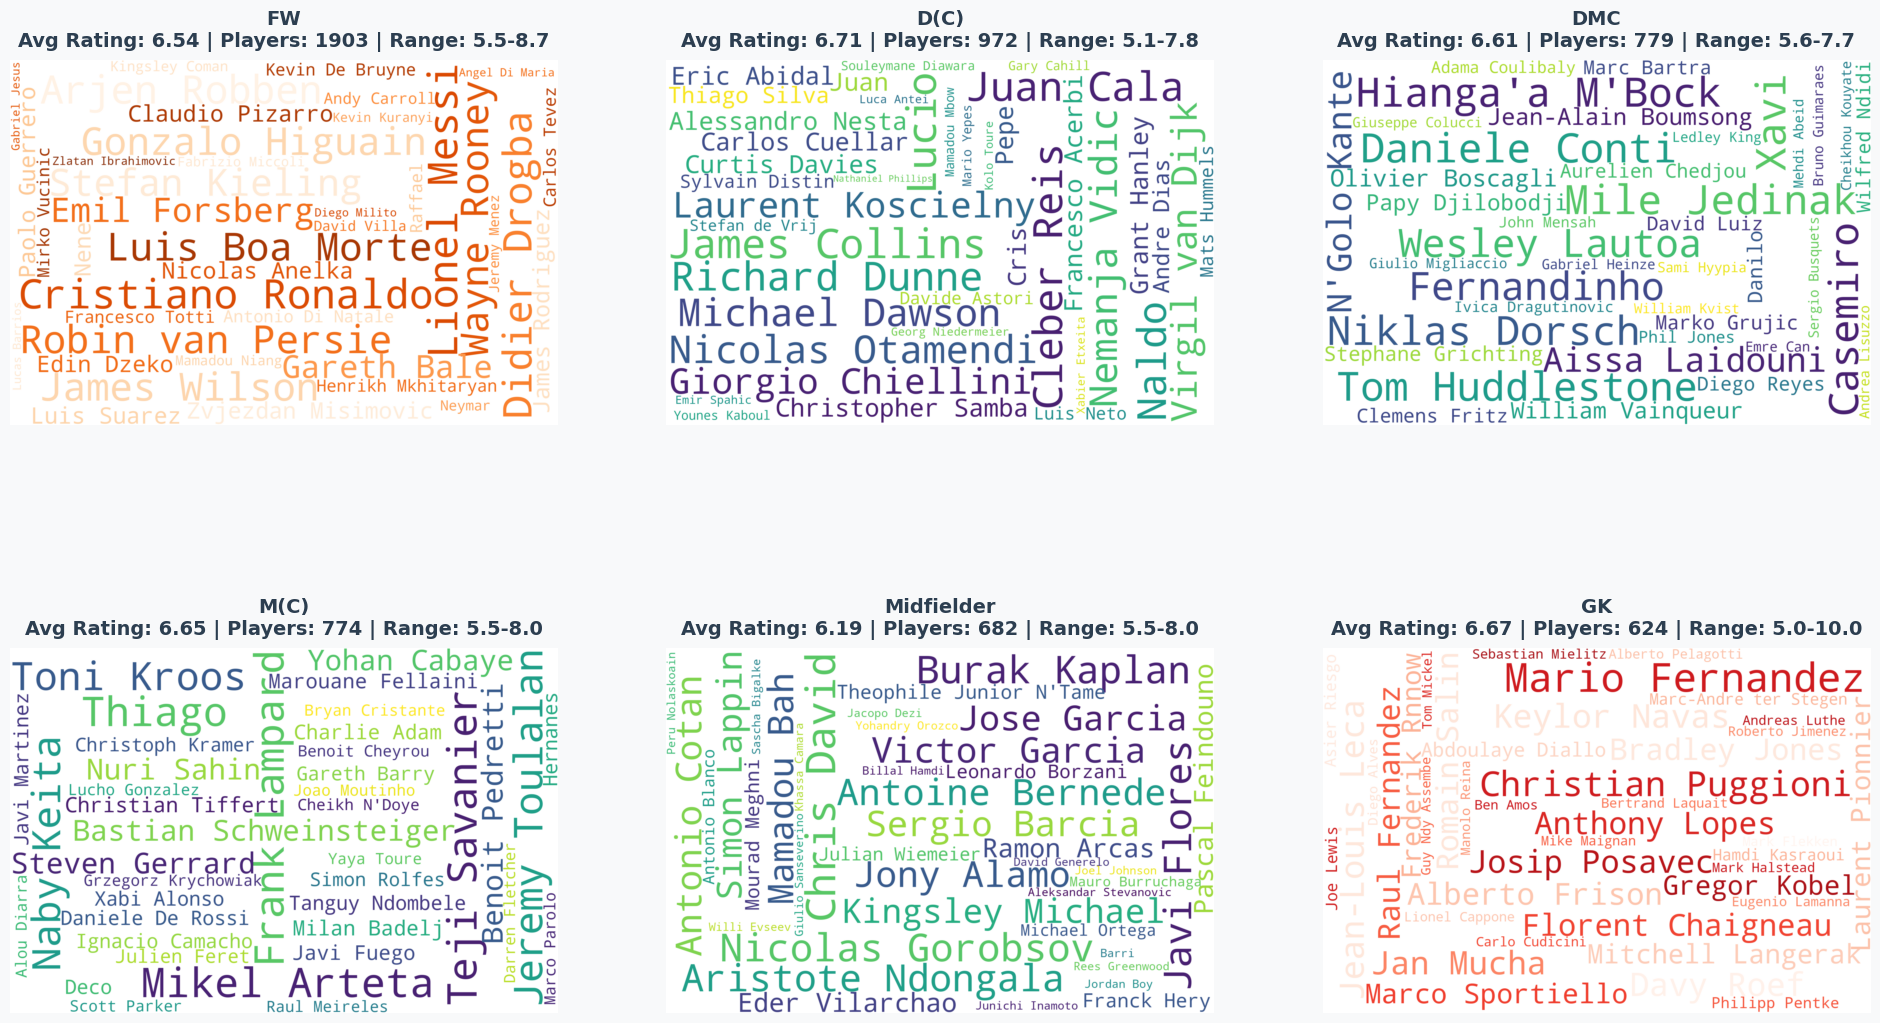

In [125]:
fig, stats = display_position_wordcloud("GK", df_clean, show_top_6=True)

Player 'Manuel Neuer' is a GK
GK Position
Position     Avg Rating   Players    Rating Range   
------------------------------------------------------------
GK                 7.12  125        7.0-7.7


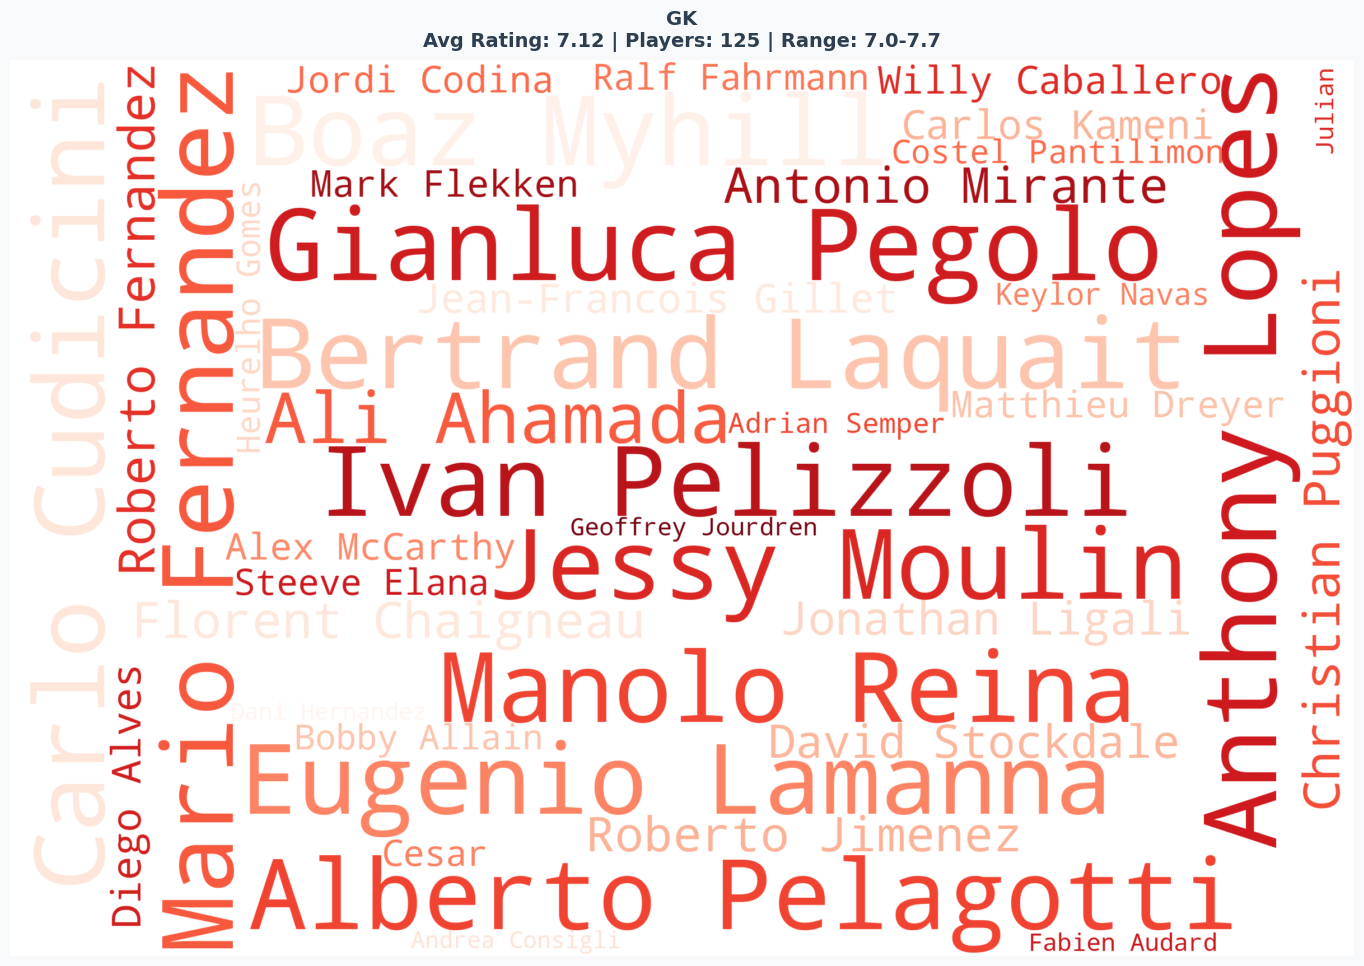

In [112]:
player_name = "Manuel Neuer"
fig, stats = create_wordcloud_for_player_position(player_name, df_data=df_full)

In [113]:
from datasketch import MinHashLSHForest
from itertools import combinations

In [99]:
# set colors
bg_color = '#f8f9fa'          
query_color = '#e74c3c'       
regular_node_color = '#95a5a6'
hub_node_color = '#f39c12'    
hub_edge_color = '#e67e22'    
query_edge_color = '#c0392b'  
regular_edge_color = '#3498db' 
stats_text_color = '#7f8c8d'  
label_bg_color = 'white'       
label_border_color = 'gray'    

colors = [
    bg_color,
    query_color,
    regular_node_color,
    hub_node_color,
    hub_edge_color,
    query_edge_color,
    regular_edge_color,
    stats_text_color,
    label_bg_color,
    label_border_color
]

In [100]:
def identify_hubs(G, top_k=None, min_degree=None):
    deg = dict(G.degree())
    nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)

    if top_k is not None:
        hubs = dict(nodes[:top_k])
    elif min_degree is not None:
        hubs = {n: d for n, d in deg.items() if d >= min_degree}
    else:
        k = max(1, len(nodes) * 20 // 100)
        hubs = dict(nodes[:k])

    return hubs, set(hubs)

In [101]:
def create_backbone_graph(G, method='top_k', alpha=0.05, top_edges=None):
    graph = nx.Graph()
    graph.add_nodes_from(G.nodes(data=True))

    if top_edges is None:
        top_edges = max(1, len(G.edges()) // 2)

    ew = sorted(
        [(u, v, G[u][v].get('weight', 0)) for u, v in G.edges()],
        key=lambda x: x[2],
        reverse=True
    )

    for u, v, _ in ew[:top_edges]:
        B.add_edge(u, v, **G[u][v])

    return graph

In [102]:
def visualize_backbone_with_hubs(G, hubs, query_player_name, backbone=None, 
                                 layout='spring', figsize=(16, 12), 
                                 highlight_hubs=True, hub_size_multiplier=3.0):
    if backbone is None: backbone = G
    if len(backbone.nodes()) == 0:
        print("Backbone graph is empty. Cannot visualize."); return None

    fig, ax = plt.subplots(figsize=figsize, facecolor=bg_color)
    hub_set = set(hubs.keys())

    # Layout
    try:
        pos = {'spring': nx.spring_layout, 'circular': nx.circular_layout,
               'kamada_kawai': nx.kamada_kawai_layout}[layout](backbone, scale=1.5, center=(0,0))
    except: pos = nx.spring_layout(backbone, k=2, iterations=100, seed=42, center=(0,0), scale=1.5)

    # Edge widths & colors
    weights = [backbone[u][v].get('weight',0.5) for u,v in backbone.edges()]
    if weights and max(weights)>min(weights): 
        edge_widths = [0.3 + (w-min(weights))/(max(weights)-min(weights))*2.7 for w in weights]
    else: edge_widths = [1.0]*len(backbone.edges())
    
    edge_colors = [hub_edge_color if highlight_hubs and (u in hub_set or v in hub_set)
                   else plt.cm.Blues(0.3+backbone[u][v].get('weight',0.5)*0.5)
                   for u,v in backbone.edges()]
    for (u,v),w,c in zip(backbone.edges(), edge_widths, edge_colors):
        nx.draw_networkx_edges(backbone, {u:pos[u], v:pos[v]}, edgelist=[(u,v)],
                               ax=ax, width=w, alpha=0.5, edge_color=c, arrows=False)

    # Nodes
    regular_nodes = [n for n in backbone.nodes() if n not in hub_set and n!=query_player_name]
    hub_nodes = [n for n in backbone.nodes() if n in hub_set and n!=query_player_name]
    query_node = [query_player_name] if query_player_name in backbone.nodes() else []

    node_sizes_dict = {}
    for node in backbone.nodes():
        rating = backbone.nodes[node].get('rating',7)
        node_sizes_dict[node] = 600 + (rating-7)*100 + backbone.degree(node)*50
    if highlight_hubs:
        for hub in hub_set: node_sizes_dict[hub] = node_sizes_dict.get(hub,0)*hub_size_multiplier
    if query_player_name in node_sizes_dict: node_sizes_dict[query_player_name]*=2.5

    if regular_nodes: nx.draw_networkx_nodes(backbone, pos, nodelist=regular_nodes, ax=ax,
                                             node_size=[node_sizes_dict[n] for n in regular_nodes],
                                             node_color=regular_node_color, alpha=0.6, edgecolors=label_bg_color, linewidths=1.5)
    if hub_nodes and highlight_hubs: nx.draw_networkx_nodes(backbone, pos, nodelist=hub_nodes, ax=ax,
                                                            node_size=[node_sizes_dict[n] for n in hub_nodes],
                                                            node_color=hub_node_color, alpha=0.9,
                                                            edgecolors=hub_edge_color, linewidths=3.0)
    if query_node: nx.draw_networkx_nodes(backbone, pos, nodelist=query_node, ax=ax,
                                          node_size=[node_sizes_dict[n] for n in query_node],
                                          node_color=query_color, alpha=0.95,
                                          edgecolors=query_edge_color, linewidths=4.0)

    # Labels
    labels = {n:(n[:12]+'...' if len(n)>15 else n) for n in backbone.nodes()}
    for n in backbone.nodes():
        if n == query_player_name:
            nx.draw_networkx_labels(backbone, {n:pos[n]}, labels={n:labels[n]}, ax=ax,
                                   font_size=10, font_weight='bold', font_color=label_bg_color,
                                   bbox=dict(boxstyle='round,pad=0.3', facecolor=query_edge_color, alpha=0.9, edgecolor=label_bg_color, linewidth=2))
        elif n in hub_set and highlight_hubs:
            nx.draw_networkx_labels(backbone, {n:pos[n]}, labels={n:labels[n]}, ax=ax,
                                   font_size=9, font_weight='bold', font_color=label_bg_color,
                                   bbox=dict(boxstyle='round,pad=0.2', facecolor=hub_edge_color, alpha=0.8, edgecolor=label_bg_color, linewidth=1.5))

    # Legend
    legend_elements = [mpatches.Patch(facecolor=query_color, edgecolor=query_edge_color, linewidth=3, label='Query Player', alpha=0.95)]
    if hub_nodes and highlight_hubs: legend_elements.append(mpatches.Patch(facecolor=hub_node_color, edgecolor=hub_edge_color, linewidth=2, label=f'Hubs ({len(hub_nodes)})', alpha=0.9))
    legend_elements.append(mpatches.Patch(facecolor=regular_node_color, edgecolor=label_bg_color, linewidth=1.5, label='Regular Nodes', alpha=0.6))
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11, framealpha=0.95, fancybox=True, shadow=True, edgecolor=label_border_color, facecolor=label_bg_color).get_frame().set_linewidth(2)

    ax.axis('off')
    ax.set_xlim([min([p[0] for p in pos.values()])*1.2, max([p[0] for p in pos.values()])*1.2])
    ax.set_ylim([min([p[1] for p in pos.values()])*1.2, max([p[1] for p in pos.values()])*1.2])
    ax.set_title('Backbone Highlighting High-Degree Hubs', fontsize=16, fontweight='bold', pad=20)
    ax.text(0.5, 0.02, f'Hubs: {len(hub_set)} | Nodes: {len(backbone.nodes())} | Edges: {len(backbone.edges())}',
            transform=ax.transAxes, fontsize=12, ha='center', va='bottom',
            color=stats_text_color, bbox=dict(boxstyle='round', facecolor=label_bg_color, alpha=0.8, pad=5))
    plt.tight_layout(); plt.show()
    return fig

In [103]:
def display_backbone_visualization(player_name, n_similar=20, similarity_threshold=0.7,
                                  hub_method='top_k', hub_k=5, backbone_method='disparity',
                                  layout='spring', figsize=(16, 12),
                                  lsh=None, minhash_list=None, X_data=None, 
                                  df_data=None, player_name_to_idx_map=None,
                                  find_similar_players_lsh=None):

    results, exec_time, mem_usage = find_similar_players_lsh(
        player_name, n_similar=n_similar, lsh=lsh, minhash_list=minhash_list,
        X_data=X_data, df_data=df_data, player_name_to_idx_map=player_name_to_idx_map
    )
    
    query_player = results.iloc[0]
    print(f"Rating: {query_player['rating']:.2f}")
    if 'cluster_name' in results.columns:
        print(f"Cluster: {query_player.get('cluster_name', 'N/A')}")

    G = plot_similar_players_network(
        query_player['name'], results, X_data=X_data, df_data=df_data,
        player_name_to_idx_map=player_name_to_idx_map,
        similarity_threshold=similarity_threshold
    )
    if len(G.nodes()) == 0:
        print("Graph is empty. Cannot create backbone visualization.")
        return None, None, None, None

    print(f"Original graph: {len(G.nodes())} nodes, {len(G.edges())} edges")

    if hub_method == 'top_k':
        hubs, hub_set = identify_hubs(G, top_k=hub_k)
    elif hub_method == 'min_degree':
        min_deg = max(2, int(np.percentile([G.degree(n) for n in G.nodes()], 75)))
        hubs, hub_set = identify_hubs(G, min_degree=min_deg)
    else:
        hubs, hub_set = identify_hubs(G)

    backbone = create_backbone_graph(G, method=backbone_method, alpha=0.05)
    print(f"Backbone graph: {len(backbone.nodes())} nodes, {len(backbone.edges())} edges")
    print(f"Edge reduction: {len(G.edges()) - len(backbone.edges())} "
          f"({(1 - len(backbone.edges())/len(G.edges()))*100:.1f}% reduction)")

    fig = visualize_backbone_with_hubs(
        G, hubs, query_player['name'], backbone=backbone,
        layout=layout, figsize=figsize,
        highlight_hubs=True, hub_size_multiplier=3.0
    )

    return results, G, backbone, hubs


In [105]:
# if 'G_original' in globals() and G_original is not None and len(G_original.nodes()) > 0:
#     player_name = globals().get('player_name', "Manuel Neuer")

#     method = 'top_k'
#     backbone = create_backbone_graph(G_original, method=method, alpha=0.05, top_edges=len(G_original.edges())//2)
#     reduction = (1 - len(backbone.edges()) / len(G_original.edges())) * 100
#     print(f"\n{method.upper()} method:")
#     print(f"  Nodes: {len(backbone.nodes())} ({len(backbone.nodes())/len(G_original.nodes())*100:.1f}% of original)")
#     print(f"  Edges: {len(backbone.edges())} ({reduction:.1f}% reduction)")

#     hubs, hub_set = identify_hubs(G_original, top_k=10)

#     fig, ax = plt.subplots(figsize=(16, 12))
#     fig.suptitle(f'Backbone Visualization (Top-K Method) - {player_name}', fontsize=16, fontweight='bold', y=0.98)
#     ax.set_facecolor(bg_color)

#     pos = nx.spring_layout(backbone, k=2, iterations=50, seed=42)

#     # Edge colors
#     edge_colors = [hub_edge_color if u in hub_set or v in hub_set else regular_edge_color for u, v in backbone.edges()]
#     nx.draw_networkx_edges(backbone, pos, ax=ax, edge_color=edge_colors, alpha=0.4, width=0.5, arrows=False)

#     # Nodes
#     regular_nodes = [n for n in backbone.nodes() if n not in hub_set and n != player_name]
#     hub_nodes = [n for n in backbone.nodes() if n in hub_set and n != player_name]
#     query_nodes = [n for n in backbone.nodes() if n == player_name]

#     if regular_nodes:
#         nx.draw_networkx_nodes(backbone, pos, nodelist=regular_nodes, ax=ax,
#                                node_color=regular_node_color, node_size=200, alpha=0.6)
#     if hub_nodes:
#         nx.draw_networkx_nodes(backbone, pos, nodelist=hub_nodes, ax=ax,
#                                node_color=hub_node_color, node_size=800, alpha=0.9)
#     if query_nodes:
#         nx.draw_networkx_nodes(backbone, pos, nodelist=query_nodes, ax=ax,
#                                node_color=query_color, node_size=1200, alpha=0.95)

#     # Labels
#     if query_nodes:
#         nx.draw_networkx_labels(backbone, pos, {n: n for n in query_nodes}, ax=ax,
#                                 font_size=9, font_weight='bold', font_color=label_color)
#     if hub_nodes:
#         nx.draw_networkx_labels(backbone, pos, {n: n for n in hub_nodes}, ax=ax,
#                                 font_size=8, font_weight='bold', font_color=label_color)

#     ax.set_title(f'Top-K Method\n{len(backbone.edges())} edges', fontsize=14, fontweight='bold')
#     ax.axis('off')

#     plt.tight_layout()
#     plt.show()